In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

## Load and process data

In [ ]:
# Load data
df_clinical = pd.read_csv('_data/clinical_and_registery.csv').set_index('pnr')
df_clinical['year'] = df_clinical['start'].apply(lambda x: int(x[:4]))


As the incidence seems to vary in the first assigments, I extracted the year of treatment start to be able to correct for it later. I also kept the variables created in the second assigment for correction. 

I just checks that the different included variables were not too correlated, and thus describing different aspects of the disease. 

In [3]:
display(df_clinical[['crp', 'pain', 'tjc', 'sjc',
       'nb_any_inpatient_event', 'nb_i_inpatient_event',
       'nb_i_outpatient_event', 'year']].corr().round(2))

,crp,pain,tjc,sjc,nb_any_inpatient_event,nb_i_inpatient_event,nb_i_outpatient_event,year
crp,1.00,0.21,0.07,0.25,0.10,0.01,0.03,-0.07
pain,0.21,1.00,0.30,0.20,0.06,0.00,0.02,0.01
tjc,0.07,0.30,1.00,0.48,-0.05,0.01,0.02,-0.03
sjc,0.25,0.20,0.48,1.00,-0.08,0.03,0.01,-0.12
nb_any_inpatient_event,0.10,0.06,-0.05,-0.08,1.00,0.18,0.07,-0.05
nb_i_inpatient_event,0.01,0.00,0.01,0.03,0.18,1.00,0.37,0.03
nb_i_outpatient_event,0.03,0.02,0.02,0.01,0.07,0.37,1.00,0.04
year,-0.07,0.01,-0.03,-0.12,-0.05,0.03,0.04,1.00


In the analysis of the first assignements, we have seen that there were missing data. There are different ways of handling missing data in terms of imputation or modelling. Here I decided to use a model that require data imputation or exclusion of patients with missing data. In an ideal world some discussion with clinicians can help understand if the data are missing at random or not. What I did to check the assumption of missing at random was to compare the distribution between patient with no missing data and patient with at least one missing data. Not that this analysis could be improved but was choosen for the sake of simplicity. 

In [4]:
df_clinical["nb_missing"] = df_clinical.isna().sum(axis = 1)

# For continuous data
for col in ['crp', 'pain', 'tjc', 'sjc','fu_trt']:
    print(col, ttest_ind(df_clinical[df_clinical["nb_missing"]==0][col], df_clinical[df_clinical["nb_missing"]>0][col].dropna()))

# For ordial data
for col in ['nb_any_inpatient_event', 'nb_i_inpatient_event',
       'nb_i_outpatient_event', "year", 'stopped_trt']:
    u, p_value = mannwhitneyu(df_clinical[df_clinical["nb_missing"]==0][col], 
                              df_clinical[df_clinical["nb_missing"]>0][col].dropna())
    u = u/(len(df_clinical[df_clinical["nb_missing"]==0][col])*len(df_clinical[df_clinical["nb_missing"]>0][col].dropna()))
    print(col, round(u, 2), round(p_value, 3))

crp TtestResult(statistic=-0.05637701035644515, pvalue=0.9550531413151793, df=965.0)
pain TtestResult(statistic=-0.36074742579610847, pvalue=0.7183727340331914, df=902.0)
tjc TtestResult(statistic=-0.09325830854990179, pvalue=0.9257178926516274, df=956.0)
sjc TtestResult(statistic=0.5900928561407182, pvalue=0.5552678454075916, df=956.0)
fu_trt TtestResult(statistic=1.064028907543311, pvalue=0.28753273833303133, df=1183.0)
nb_any_inpatient_event 0.5 0.827
nb_i_inpatient_event 0.5 0.708
nb_i_outpatient_event 0.5 0.702
year 0.44 0.002
stopped_trt 0.5 0.989


What we see here is that missing values are dependent of the year of inclusion, hopefully this is not the main variable of interest of our study. We will assume here that the inclusion criteria did not change over the years and impute missing data with the mean to try not to loose to much power. 

# Analyse method 

### Separated analysis for treatments:
First, the two treatment might have different impact on the stopping dtae. Thus instead of including all the interactions with the other variables, I rather separate the analysis for the two treatments. 

### Correction:
Then we are interested in the effect of drug, CRP, pain, TJC and SJC yet to make sure there effect is not related to an other cofounding, we also correct for the different variables studied in the other assigments: the tree variable linked to the registeries events and the year of treatment start. Note that to limit the dicrease of power I did not includ interaction between and with correction variables. 

### Model choice:


### Metric of evaluation:


In [5]:
correction = "+ nb_any_inpatient_event + nb_i_inpatient_event + nb_i_outpatient_event + year"
features = ['crp', 'pain', 'tjc', 'sjc']

## Treatment A

In [6]:
df_a = df_clinical[df_clinical['drug'] == 'A']
df_a[features] = df_a[features].fillna(df_a[features].mean())

/var/folders/n_/wh4ydpjn59g0f2cvgdpg6cs40000gq/T/ipykernel_21863/1934714725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a[features] = df_a[features].fillna(df_a[features].mean())


Are the missing values at random ?  First, I test the columns of interest with pairwise interactions with the correction variables. 

In [7]:
cph = CoxPHFitter()
cph.fit(df_a, duration_col='fu_trt', event_col='stopped_trt', 
                formula="crp + pain + tjc + sjc + crp * pain + crp * tjc + crp * sjc + pain * tjc + pain * sjc + tjc * sjc " + correction)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 687 total observations, 323 right-censored observations>
             duration col = 'fu_trt'
                event col = 'stopped_trt'
      baseline estimation = breslow
   number of observations = 687
number of events observed = 364
   partial log-likelihood = -2214.91
         time fit was run = 2025-04-14 09:25:38 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
crp                     0.01      1.01      0.01           -0.00            0.03                1.00                1.03
pain                    0.01      1.01      0.00            0.00            0.02                1.00                1.02
tjc                    -0.00      1.00      0.04           -0.08            0.07                0.93                1.07
sjc                     0.02      1.02      0.04           -0.07            0.10                0.94                1.11
nb_any_inpatient_event  0.03      1.04      0.03           -0.02            0.09                0.98                1.10
nb_i_inpatient_event   -0.01      0.99      0.24           -0.49            0.46                0.62                1.59
nb_i_outpatient_event  -0.63      0.53      0.91           -2.41            1.14                0.09                3.14
year                   -0.03      0.97      0.03           -0.08            0.03                0.92                1.03
crp:pain               -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
crp:tjc                 0.00      1.00      0.00           -0.00            0.00                1.00                1.00
crp:sjc                 0.00      1.00      0.00           -0.00            0.00                1.00                1.00
pain:tjc                0.00      1.00      0.00           -0.00            0.00                1.00                1.00
pain:sjc               -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
tjc:sjc                -0.00      1.00      0.00           -0.01            0.00                0.99                1.00

                        cmp to     z      p  -log2(p)
covariate                                            
crp                       0.00  1.71   0.09      3.51
pain                      0.00  2.91 <0.005      8.13
tjc                       0.00 -0.12   0.91      0.14
sjc                       0.00  0.42   0.68      0.56
nb_any_inpatient_event    0.00  1.17   0.24      2.05
nb_i_inpatient_event      0.00 -0.05   0.96      0.06
nb_i_outpatient_event     0.00 -0.70   0.48      1.05
year                      0.00 -1.04   0.30      1.73
crp:pain                  0.00 -2.18   0.03      5.11
crp:tjc                   0.00  0.52   0.60      0.73
crp:sjc                   0.00  1.04   0.30      1.75
pain:tjc                  0.00  0.27   0.78      0.35
pain:sjc                  0.00 -0.06   0.95      0.07
tjc:sjc                   0.00 -1.12   0.26      1.92
---
Concordance = 0.58
Partial AIC = 4457.83
log-likelihood ratio test = 32.13 on 14 df
-log2(p) of ll-ratio test = 8.03

Some associations were found: [!! WARNING ROUND]
- crp:  1.02 [1.00, 103] (p-value: 0.04)
- pain: 1.01 [1.00, 1.02] (p-value < 0.005)
- crp:pain: 1.00 [1.00, 1.00] (p-value: 0.01)

I just checked the assumption on proportionnal hazard. Note that here I plot all the different indicators, as there was an issue with the years, but I did not for the other analysis as it takes quite a bit of space.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See lin

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 687 total observations, 323 right-censored observations>
         test_name = proportional_hazard_test

---
                             test_statistic    p  -log2(p)
crp                    km              1.22 0.27      1.90
                       rank            1.15 0.28      1.82
crp:pain               km              1.37 0.24      2.05
                       rank            1.36 0.24      2.04
crp:sjc                km              0.19 0.66      0.59
                       rank            0.19 0.67      0.59
crp:tjc                km              0.50 0.48      1.06
                       rank            0.52 0.47      1.09
nb_any_inpatient_event km              1.64 0.20      2.32
                       rank            1.65 0.20      2.33
nb_i_inpatient_event   km              0.93 0.34      1.58
                       rank            0.90 0.34      1.55
nb_i_outpatient_event  km              1.26 0.26      1.94
                       rank            1.31 0.25      1.99
pain                   km              3.20 0.07      3.76
                       rank            3.18 0.07      3.74
pain:sjc               km              0.05 0.82      0.29
                       rank            0.04 0.84      0.26
pain:tjc               km              0.63 0.43      1.22
                       rank            0.61 0.43      1.21
sjc                    km              0.15 0.70      0.51
                       rank            0.13 0.72      0.47
tjc                    km              0.12 0.73      0.46
                       rank            0.11 0.74      0.43
tjc:sjc                km              0.34 0.56      0.84
                       rank            0.37 0.54      0.88
year                   km              5.16 0.02      5.44
                       rank            5.18 0.02      5.45



1. Variable 'year' failed the non-proportional test: p-value is 0.0228.

   Advice 1: the functional form of the variable 'year' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'year' using pd.cut, and then specify it in `strata=['year',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/l

[[<Axes: xlabel='rank-transformed time\n(p=0.2832)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2684)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0748)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0736)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7399)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7271)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7206)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7022)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1988)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1997)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3425)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3353)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2518)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2607)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0228)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0231)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2440)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2414)'>],
 [<Axes: xlabel='rank-transformed tim

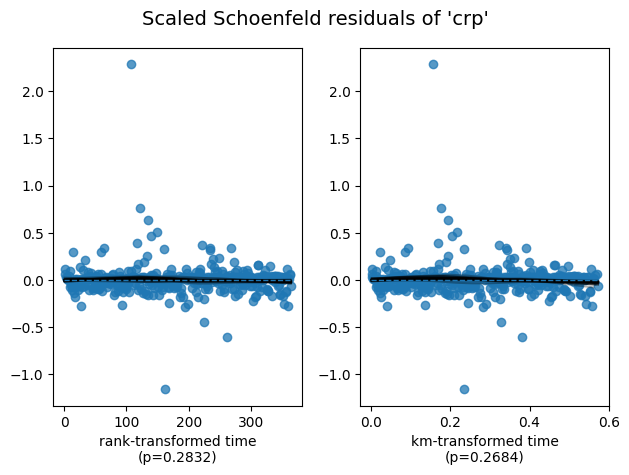

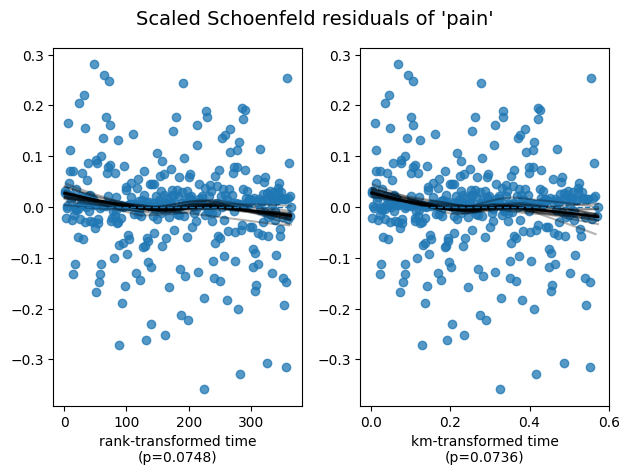

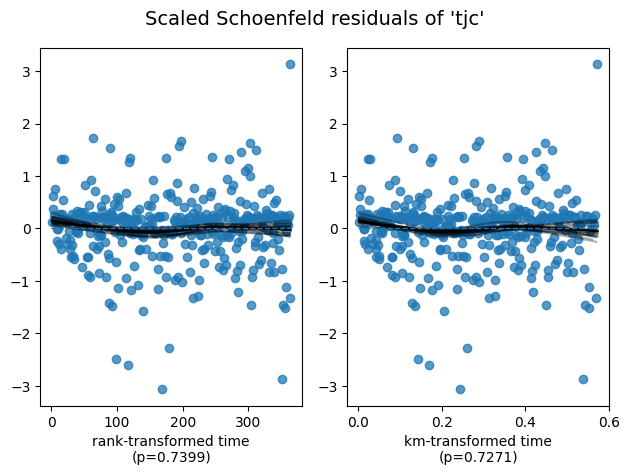

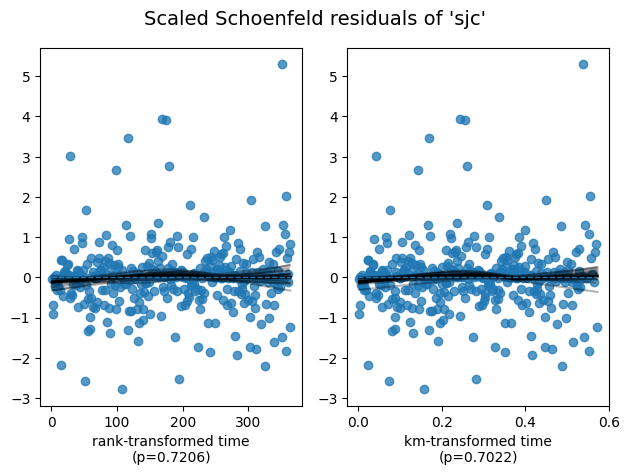

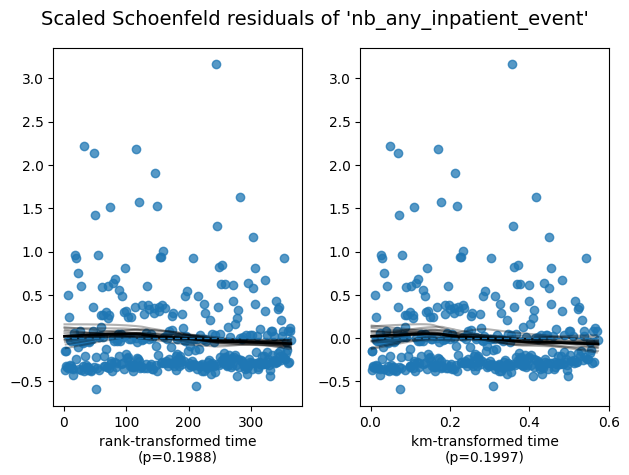

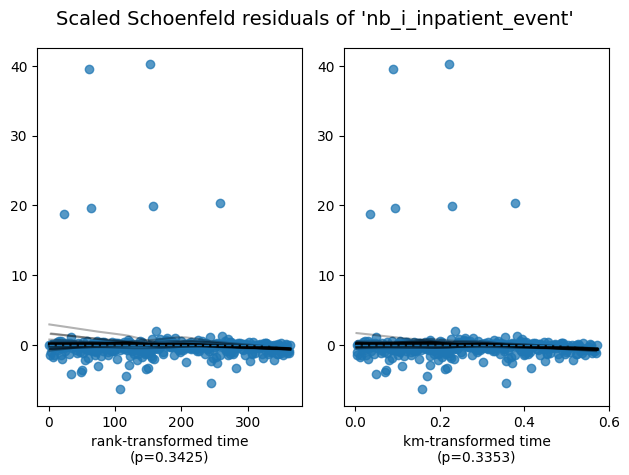

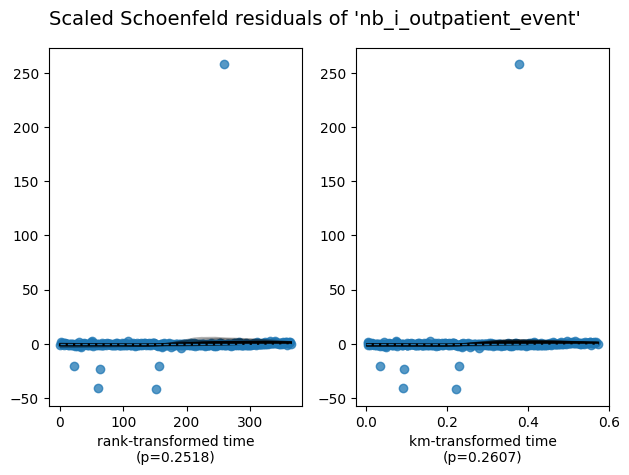

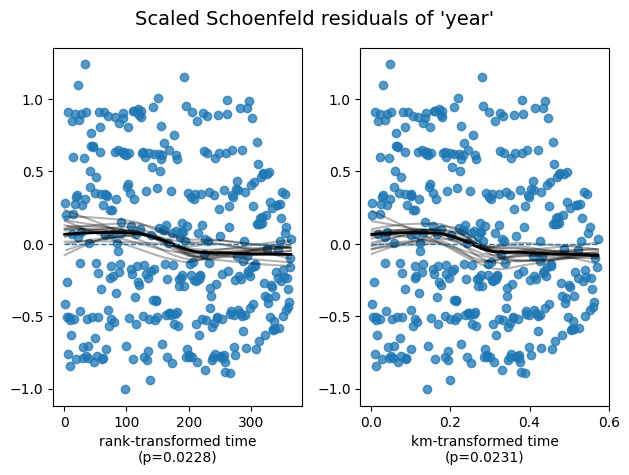

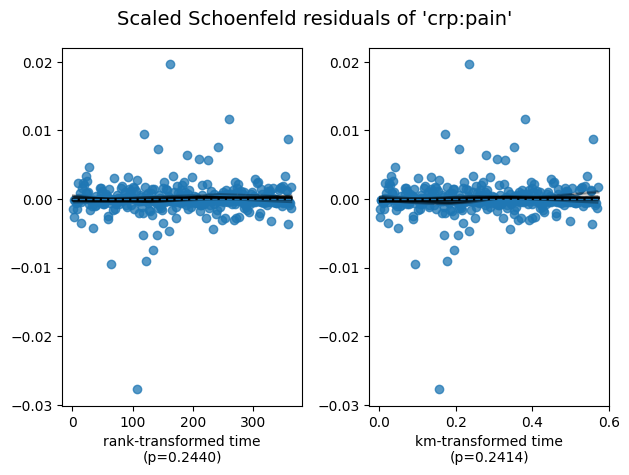

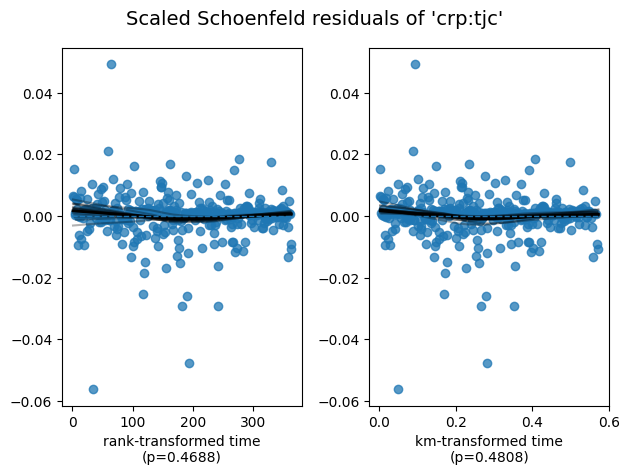

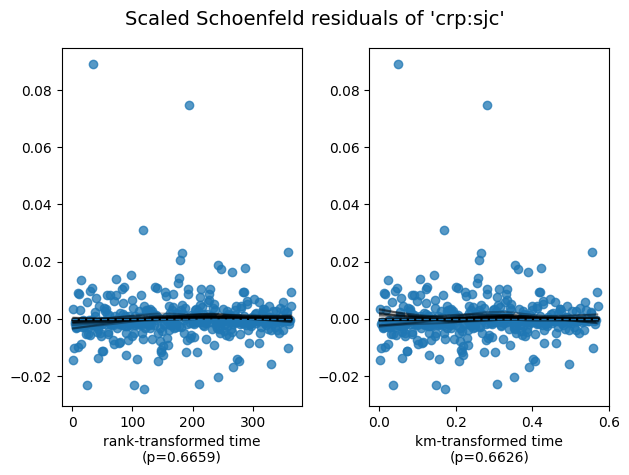

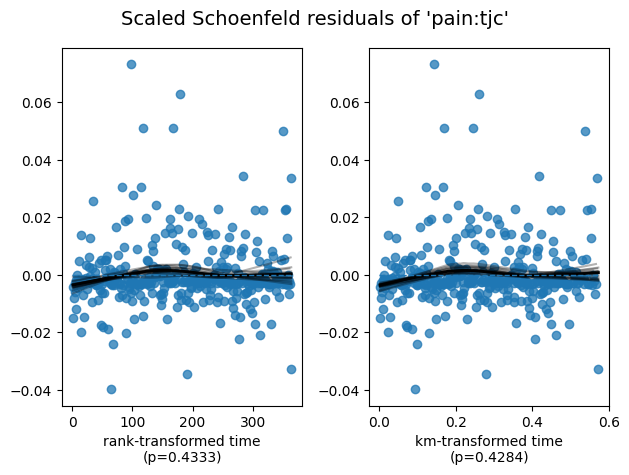

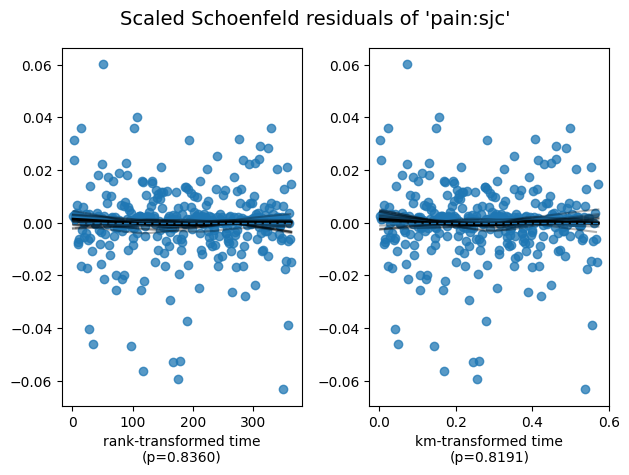

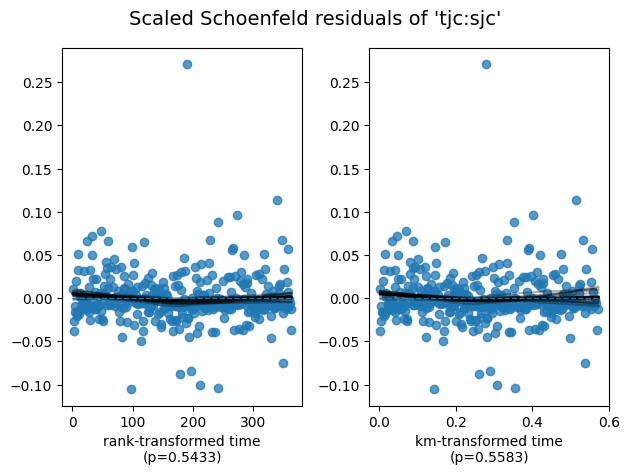

In [8]:
cph.check_assumptions(df_a, p_value_threshold=0.05, show_plots=True)

## Treatment B

In [9]:
df_b = df_clinical[df_clinical['drug'] == 'B']
df_b[features] = df_b[features].fillna(df_b[features].mean())


/var/folders/n_/wh4ydpjn59g0f2cvgdpg6cs40000gq/T/ipykernel_21863/3906059678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b[features] = df_b[features].fillna(df_b[features].mean())


Are the missing values at random ?  First, I test the columns of interest with pairwise interactions with the correction variables. 

In [10]:
cph = CoxPHFitter()
cph.fit(df_b, duration_col='fu_trt', event_col='stopped_trt', 
                formula="crp + pain + tjc + sjc + crp * pain + crp * tjc + crp * sjc + pain * tjc + pain * sjc + tjc * sjc " + correction)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 498 total observations, 321 right-censored observations>
             duration col = 'fu_trt'
                event col = 'stopped_trt'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 177
   partial log-likelihood = -1029.78
         time fit was run = 2025-04-14 09:25:45 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
crp                    -0.00      1.00      0.01           -0.03            0.02                0.97                1.03
pain                    0.00      1.00      0.01           -0.01            0.02                0.99                1.02
tjc                     0.03      1.04      0.05           -0.06            0.13                0.94                1.14
sjc                    -0.04      0.96      0.06           -0.16            0.08                0.85                1.08
nb_any_inpatient_event -0.01      0.99      0.03           -0.07            0.04                0.93                1.04
nb_i_inpatient_event    0.33      1.40      0.31           -0.28            0.94                0.76                2.57
nb_i_outpatient_event  -0.68      0.51      1.07           -2.79            1.43                0.06                4.16
year                    0.03      1.03      0.04           -0.06            0.11                0.94                1.12
crp:pain               -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
crp:tjc                 0.00      1.00      0.00           -0.00            0.00                1.00                1.00
crp:sjc                -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
pain:tjc               -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
pain:sjc                0.00      1.00      0.00           -0.00            0.00                1.00                1.00
tjc:sjc                -0.00      1.00      0.00           -0.01            0.00                0.99                1.00

                        cmp to     z    p  -log2(p)
covariate                                          
crp                       0.00 -0.07 0.95      0.08
pain                      0.00  0.60 0.55      0.87
tjc                       0.00  0.72 0.47      1.09
sjc                       0.00 -0.63 0.53      0.91
nb_any_inpatient_event    0.00 -0.48 0.63      0.67
nb_i_inpatient_event      0.00  1.08 0.28      1.83
nb_i_outpatient_event     0.00 -0.63 0.53      0.93
year                      0.00  0.63 0.53      0.91
crp:pain                  0.00 -0.02 0.98      0.02
crp:tjc                   0.00  1.24 0.22      2.21
crp:sjc                   0.00 -0.55 0.58      0.78
pain:tjc                  0.00 -0.54 0.59      0.77
pain:sjc                  0.00  0.70 0.49      1.04
tjc:sjc                   0.00 -0.67 0.50      0.99
---
Concordance = 0.55
Partial AIC = 2087.55
log-likelihood ratio test = 9.23 on 14 df
-log2(p) of ll-ratio test = 0.29

In [11]:
cph.check_assumptions(df_b, p_value_threshold=0.05, show_plots=False)

Proportional hazard assumption looks okay.


[]

No significant results, test without interaction. 

In [12]:
cph = CoxPHFitter()
cph.fit(df_b.dropna(), duration_col='fu_trt', event_col='stopped_trt', 
                formula="crp + pain + tjc + sjc " + correction)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 498 total observations, 321 right-censored observations>
             duration col = 'fu_trt'
                event col = 'stopped_trt'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 177
   partial log-likelihood = -1030.86
         time fit was run = 2025-04-14 09:25:45 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
crp                     0.00      1.00      0.00           -0.00            0.01                1.00                1.01
pain                    0.01      1.01      0.00           -0.00            0.01                1.00                1.01
tjc                     0.02      1.02      0.02           -0.01            0.05                0.99                1.05
sjc                    -0.03      0.97      0.02           -0.07            0.02                0.93                1.02
nb_any_inpatient_event -0.02      0.99      0.03           -0.07            0.04                0.93                1.04
nb_i_inpatient_event    0.33      1.39      0.31           -0.28            0.94                0.76                2.57
nb_i_outpatient_event  -0.66      0.52      1.07           -2.76            1.44                0.06                4.21
year                    0.03      1.03      0.04           -0.05            0.11                0.95                1.12

                        cmp to     z    p  -log2(p)
covariate                                          
crp                       0.00  0.57 0.57      0.81
pain                      0.00  1.46 0.15      2.78
tjc                       0.00  1.16 0.24      2.03
sjc                       0.00 -1.15 0.25      1.99
nb_any_inpatient_event    0.00 -0.54 0.59      0.77
nb_i_inpatient_event      0.00  1.06 0.29      1.80
nb_i_outpatient_event     0.00 -0.62 0.54      0.90
year                      0.00  0.70 0.49      1.04
---
Concordance = 0.56
Partial AIC = 2077.71
log-likelihood ratio test = 7.07 on 8 df
-log2(p) of ll-ratio test = 0.92

Nothing significant.

In [13]:
cph.check_assumptions(df_b, p_value_threshold=0.05, show_plots=False)

Proportional hazard assumption looks okay.


[]